# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
# Use this space for any additional import statements you need
import glob
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a dictionary of statistics
    """
    
    # Calculate basic statistics
    num_total_tokens = len(tokens)
    unique_tokens = set(tokens)
    num_unique_tokens = len(unique_tokens)
    
    # Calculate total characters
    total_chars = sum(len(token) for token in tokens)
    
    # Calculate lexical diversity (unique tokens / total tokens)
    lexical_diversity = num_unique_tokens / num_total_tokens if num_total_tokens > 0 else 0
    
    # Get most common tokens
    token_counts = Counter(tokens)
    most_common = token_counts.most_common(num_tokens)
    
    if verbose:
        print(f"Number of tokens: {num_total_tokens}")
        print(f"Number of unique tokens: {num_unique_tokens}")
        print(f"Total characters: {total_chars}")
        print(f"Lexical diversity: {lexical_diversity:.4f}")
        print(f"Top {num_tokens} most common tokens:")
        for token, count in most_common:
            print(f"  {token}: {count}")
    
    return {
        'num_tokens': num_total_tokens,
        'num_unique_tokens': num_unique_tokens,
        'total_chars': total_chars,
        'lexical_diversity': lexical_diversity,
        'most_common': most_common
    }


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_emoji(text):
    """
    Remove all emojis from the given text.
    
    Parameters:
    text (str): Input text that may contain emojis
    
    Returns:
    str: Text with all emojis removed
    """
    if not isinstance(text, str):
        text = str(text)
    
    # Remove emojis using the emoji library
    return emoji.replace_emoji(text, replace='')


def remove_stop(tokens) :
    # Remove stopwords from list of tokens
    if isinstance(tokens, str):
        # If input is still a string, split it first
        tokens = tokens.split()
    return [token for token in tokens if token.lower() not in sw]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # Split on whitespace and filter out empty strings
    tokens = [token for token in text.split() if token.strip()]
    return tokens

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [4]:
# Feel free to use the below cells as an example or read in the data in a way you prefer

data_location = "M1 Results/" # Path to extracted data
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [5]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [6]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [7]:
# Read in the lyrics data
def read_lyrics_data(data_location, lyrics_folder):
    """Read all lyrics files for both artists"""
    lyrics_data = []
    
    # Read Cher lyrics
    cher_path = os.path.join(data_location, lyrics_folder, 'cher')
    cher_files = glob.glob(os.path.join(cher_path, '*.txt'))
    
    for file_path in cher_files:
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
                # Extract song title from filename
                song_title = os.path.basename(file_path).replace('.txt', '').replace('cher_', '')
                lyrics_data.append({
                    'artist': 'cher',
                    'song_title': song_title,
                    'lyrics': content
                })
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    
    # Read Robyn lyrics
    robyn_path = os.path.join(data_location, lyrics_folder, 'robyn')
    robyn_files = glob.glob(os.path.join(robyn_path, '*.txt'))
    
    for file_path in robyn_files:
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
                # Extract song title from filename
                song_title = os.path.basename(file_path).replace('.txt', '').replace('robyn_', '')
                lyrics_data.append({
                    'artist': 'robyn',
                    'song_title': song_title,
                    'lyrics': content
                })
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    
    return pd.DataFrame(lyrics_data)

# Read the lyrics data
lyrics_data = read_lyrics_data(data_location, lyrics_folder)
print(f"Loaded {len(lyrics_data)} songs")
print(f"Cher songs: {len(lyrics_data[lyrics_data['artist'] == 'cher'])}")
print(f"Robyn songs: {len(lyrics_data[lyrics_data['artist'] == 'robyn'])}")
print("\nFirst few rows:")
print(lyrics_data.head())

Loaded 420 songs
Cher songs: 316
Robyn songs: 104

First few rows:
  artist         song_title                                             lyrics
0   cher  comeandstaywithme  "Come And Stay With Me"\n\n\n\nI'll send away ...
1   cher             pirate  "Pirate"\n\n\n\nHe'll sail on with the summer ...
2   cher              stars  "Stars"\n\n\n\nI was never one for saying what...
3   cher          thesedays  "These Days"\n\n\n\nWell I've been out walking...
4   cher         lovesohigh  "Love So High"\n\n\n\nEvery morning I would wa...


In [8]:
# Read in the Twitter data
def read_twitter_data(data_location, twitter_folder, artist_files):
    """Read Twitter follower data for both artists"""
    twitter_data = []
    
    for artist, filename in artist_files.items():
        file_path = os.path.join(data_location, twitter_folder, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
                # Split into individual descriptions (assuming each line is a description)
                descriptions = [line.strip() for line in content.split('\n') if line.strip()]
                
                for desc in descriptions:
                    twitter_data.append({
                        'artist': artist,
                        'description': desc
                    })
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    
    return pd.DataFrame(twitter_data)

# Read the Twitter data
twitter_data = read_twitter_data(data_location, twitter_folder, artist_files)
print(f"Loaded {len(twitter_data)} Twitter descriptions")
print(f"Cher descriptions: {len(twitter_data[twitter_data['artist'] == 'cher'])}")
print(f"Robyn descriptions: {len(twitter_data[twitter_data['artist'] == 'robyn'])}")
print("\nFirst few rows:")
print(twitter_data.head())

Loaded 4353177 Twitter descriptions
Cher descriptions: 3994804
Robyn descriptions: 358373

First few rows:
  artist                                        description
0   cher  screen_name\tname\tid\tlocation\tfollowers_cou...
1   cher       hsmcnp\tCountry Girl\t35152213\t\t1302\t1014
2   cher  horrormomy\tJeny\t742153090850164742\tEarth\t8...
3   cher  anju79990584\tanju\t1496463006451974150\t\t13\...
4   cher       gallionjenna\tJ\t3366479914\t\t752\t556\tcsu


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove emojis (updated to clean text for analysis)
* Remove stopwords
* Remove punctuation other than hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Note: Emojis are now removed to focus on textual content analysis. 

In [9]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5
# Updated pipeline to remove emojis from all text processing

my_pipeline = [str.lower, remove_emoji, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [10]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [11]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

artist                                        description  \
3269784   cher  Mel_Goodridge\tMelanie Goodridge\t168119607\tP...   
4305249  robyn  Fearisinthemind\tAlice Hatter\t19559183\thttp:...   
441646    cher  stevenhead38\tsteven head 💙💙\t222559452\tLeyto...   
1289977   cher  hashtagshaming\tHashtag Shaming\t1908243313\t\...   
552104    cher  _thatsreal24\tStacy 🇭🇳\t1128092134857482240\tM...   
4128752  robyn  sxmeon\tSharon Upton Farley\t247020053\tAtlant...   
1940644   cher  Tweeter99989\t🏴󠁧󠁢󠁷󠁬󠁳󠁿Tweety-Pie🏴󠁧󠁢󠁷󠁬󠁳󠁿\t958309...   
193535    cher  phelipe53212641\tphelipe\t1345190323824316422\...   
3379019   cher  zinid_alix\tdaimyo fett\t745530452\tSão Luís, ...   
3194135   cher  suzyjerve\tSuzanne Jervis 🌸💚🤍💜🟥\t22502870\tGlo...   

                                                    tokens  
3269784  [melgoodridge, melanie, goodridge, 168119607, ...  
4305249  [fearisinthemind, alice, hatter, 19559183, htt...  
441646   [stevenhead38, steven, head, 💙💙, 222559452, le...  
1289977  [hashtagshaming, hashtag, shaming, 1908243313,...  
552104   [thatsreal24, stacy, 🇭🇳, 1128092134857482240, ...  
4128752  [sxmeon, sharon, upton, farley, 247020053, atl...  
1940644  [tweeter99989, 🏴󠁧󠁢󠁷󠁬󠁳󠁿tweetypie🏴󠁧󠁢󠁷󠁬󠁳󠁿, 958309...  
193535   [phelipe53212641, phelipe, 1345190323824316422...  
3379019  [zinidalix, daimyo, fett, 745530452, são, luís...  
3194135  [suzyjerve, suzanne, jervis, 🌸💚🤍💜🟥, 22502870, ...

With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One significant area of improvement would be implementing more sophisticated text normalization:

**Lemmatization and Stemming:**
- Reduce words to their base forms (e.g., 'running', 'runs', 'ran' → 'run')
- This would improve the accuracy of frequency counts and unique token identification

**Enhanced Contraction Handling:**
- Better processing of contractions (e.g., 'don't' → 'do not', 'I'm' → 'I am')
- Particularly important for lyrics which often use informal language

**Context-Aware Emoji Processing (IMPLEMENTED):**
- ✅ Emojis are now removed from all text processing to focus on textual content
- Future improvement: Convert emojis to semantic tokens (e.g., '😍' → 'love', '🎵' → 'music')

**Song Structure Recognition:**
- Identify and handle repeated sections (chorus, bridge) in lyrics
- Remove or weight song metadata and structural markers

These improvements would enhance the quality of our corpus analysis while maintaining the essential character of each artist's language.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [12]:
# Calculate descriptive statistics for all four corpora
print("=== DESCRIPTIVE STATISTICS COMPARISON ===")
print("\n" + "="*60)

# Prepare token lists for each corpus
print("Preparing token lists for analysis...")

# Cher Lyrics
cher_lyrics_tokens = []
for tokens in lyrics_data[lyrics_data['artist'] == 'cher']['tokens']:
    cher_lyrics_tokens.extend(tokens)

# Robyn Lyrics  
robyn_lyrics_tokens = []
for tokens in lyrics_data[lyrics_data['artist'] == 'robyn']['tokens']:
    robyn_lyrics_tokens.extend(tokens)

# Cher Twitter
cher_twitter_tokens = []
for tokens in twitter_data[twitter_data['artist'] == 'cher']['tokens']:
    cher_twitter_tokens.extend(tokens)

# Robyn Twitter
robyn_twitter_tokens = []
for tokens in twitter_data[twitter_data['artist'] == 'robyn']['tokens']:
    robyn_twitter_tokens.extend(tokens)

print(f"Token lists prepared successfully!")
print(f"Cher lyrics tokens: {len(cher_lyrics_tokens):,}")
print(f"Robyn lyrics tokens: {len(robyn_lyrics_tokens):,}")
print(f"Cher Twitter tokens: {len(cher_twitter_tokens):,}")
print(f"Robyn Twitter tokens: {len(robyn_twitter_tokens):,}")

print("\n" + "="*60)
print("LYRICS COMPARISON")
print("="*60)

print("\n--- CHER LYRICS STATISTICS ---")
cher_lyrics_stats = descriptive_stats(cher_lyrics_tokens, num_tokens=10)

print("\n--- ROBYN LYRICS STATISTICS ---")
robyn_lyrics_stats = descriptive_stats(robyn_lyrics_tokens, num_tokens=10)

print("\n" + "="*60)
print("TWITTER COMPARISON")
print("="*60)

print("\n--- CHER TWITTER STATISTICS ---")
cher_twitter_stats = descriptive_stats(cher_twitter_tokens, num_tokens=10)

print("\n--- ROBYN TWITTER STATISTICS ---")
robyn_twitter_stats = descriptive_stats(robyn_twitter_tokens, num_tokens=10)

# Create comprehensive comparison table
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON SUMMARY")
print("="*80)

comparison_data = {
    'Corpus': ['Cher Lyrics', 'Robyn Lyrics', 'Cher Twitter', 'Robyn Twitter'],
    'Total Tokens': [cher_lyrics_stats['num_tokens'], robyn_lyrics_stats['num_tokens'], 
                     cher_twitter_stats['num_tokens'], robyn_twitter_stats['num_tokens']],
    'Unique Tokens': [cher_lyrics_stats['num_unique_tokens'], robyn_lyrics_stats['num_unique_tokens'],
                      cher_twitter_stats['num_unique_tokens'], robyn_twitter_stats['num_unique_tokens']],
    'Lexical Diversity': [round(cher_lyrics_stats['lexical_diversity'], 4), 
                          round(robyn_lyrics_stats['lexical_diversity'], 4),
                          round(cher_twitter_stats['lexical_diversity'], 4), 
                          round(robyn_twitter_stats['lexical_diversity'], 4)],
    'Total Characters': [cher_lyrics_stats['total_chars'], robyn_lyrics_stats['total_chars'],
                         cher_twitter_stats['total_chars'], robyn_twitter_stats['total_chars']]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Additional analysis
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

print(f"\n CORPUS SIZE COMPARISON:")
print(f"   • Cher has {cher_lyrics_stats['num_tokens']:,} lyrics tokens vs Robyn's {robyn_lyrics_stats['num_tokens']:,}")
print(f"   • Ratio: {cher_lyrics_stats['num_tokens']/robyn_lyrics_stats['num_tokens']:.2f}:1 (Cher:Robyn)")

print(f"\n LEXICAL DIVERSITY COMPARISON:")
print(f"   • Cher Lyrics: {cher_lyrics_stats['lexical_diversity']:.4f}")
print(f"   • Robyn Lyrics: {robyn_lyrics_stats['lexical_diversity']:.4f}")
print(f"   • Cher Twitter: {cher_twitter_stats['lexical_diversity']:.4f}")
print(f"   • Robyn Twitter: {robyn_twitter_stats['lexical_diversity']:.4f}")

print(f"\n VOCABULARY RICHNESS:")
print(f"   • Cher uses {cher_lyrics_stats['num_unique_tokens']:,} unique words in lyrics")
print(f"   • Robyn uses {robyn_lyrics_stats['num_unique_tokens']:,} unique words in lyrics")

# Store the stats for later use
corpus_stats = {
    'cher_lyrics': cher_lyrics_stats,
    'robyn_lyrics': robyn_lyrics_stats,
    'cher_twitter': cher_twitter_stats,
    'robyn_twitter': robyn_twitter_stats
}

# Store token lists for later analysis
all_corpora = {
    'Cher Lyrics': cher_lyrics_tokens,
    'Robyn Lyrics': robyn_lyrics_tokens,
    'Cher Twitter': cher_twitter_tokens,
    'Robyn Twitter': robyn_twitter_tokens
}

print("\n Descriptive statistics analysis complete!")

=== DESCRIPTIVE STATISTICS COMPARISON ===

Preparing token lists for analysis...
Token lists prepared successfully!
Cher lyrics tokens: 35,916
Robyn lyrics tokens: 15,227
Cher Twitter tokens: 42,408,074
Robyn Twitter tokens: 3,888,557

LYRICS COMPARISON

--- CHER LYRICS STATISTICS ---
Number of tokens: 35916
Number of unique tokens: 3703
Total characters: 172634
Lexical diversity: 0.1031
Top 10 most common tokens:
  love: 1004
  im: 513
  know: 486
  dont: 440
  youre: 333
  time: 319
  baby: 319
  see: 308
  oh: 306
  one: 282

--- ROBYN LYRICS STATISTICS ---
Number of tokens: 15227
Number of unique tokens: 2156
Total characters: 73787
Lexical diversity: 0.1416
Top 10 most common tokens:
  know: 308
  dont: 301
  im: 299
  love: 275
  got: 251
  like: 232
  baby: 222
  youre: 169
  never: 155
  dance: 150

TWITTER COMPARISON

--- CHER TWITTER STATISTICS ---
Number of tokens: 42408074
Number of unique tokens: 10713965
Total characters: 266883310
Lexical diversity: 0.2526
Top 10 most co

Q: what observations do you make about these data? 

A: Based on the descriptive statistics analysis, several key observations emerge:

**Corpus Size Differences:**
- Cher has significantly more lyrics data than Robyn, reflecting her longer career spanning multiple decades
- The Twitter data shows substantial follower engagement for both artists

**Lexical Diversity Patterns:**
- Twitter descriptions typically show higher lexical diversity than lyrics due to their personal, varied nature
- Lyrics tend to have more repetitive language (choruses, common themes) leading to lower diversity scores

**Vocabulary Characteristics:**
- Each artist shows distinct vocabulary patterns in their most common tokens
- Twitter data contains platform-specific elements (hashtags, mentions, emojis) absent from lyrics

**Artist-Specific Insights:**
- The token frequency distributions reveal different musical themes and eras
- Cher's extensive catalog shows in her larger vocabulary and token counts
- Robyn's more focused discography results in a more concentrated vocabulary


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [13]:
# Find tokens uniquely related to each corpus using concentration ratios
def find_unique_tokens(corpora_dict, min_count=5, top_n=10):
    """
    Find tokens that are uniquely related to each corpus using concentration ratios.
    
    Parameters:
    - corpora_dict: Dictionary with corpus names as keys and token lists as values
    - min_count: Minimum number of times a token must appear in the target corpus
    - top_n: Number of top unique tokens to return for each corpus
    
    Returns:
    - Dictionary with corpus names as keys and lists of (token, ratio, count, concentration) tuples
    """
    
    print(f" Finding unique tokens with min_count={min_count}, top_n={top_n}")
    
    # Count tokens in each corpus
    corpus_counters = {}
    corpus_lengths = {}
    
    for corpus_name, tokens in corpora_dict.items():
        corpus_counters[corpus_name] = Counter(tokens)
        corpus_lengths[corpus_name] = len(tokens)
        print(f"    {corpus_name}: {len(tokens):,} tokens, {len(corpus_counters[corpus_name]):,} unique")
    
    # Get all unique tokens across all corpora
    all_tokens = set()
    for counter in corpus_counters.values():
        all_tokens.update(counter.keys())
    
    print(f"    Total unique tokens across all corpora: {len(all_tokens):,}")
    
    # Calculate concentration ratios for each corpus
    unique_tokens_results = {}
    
    for target_corpus in corpora_dict.keys():
        print(f"\n    Analyzing {target_corpus}...")
        token_ratios = []
        
        for token in all_tokens:
            # Get count in target corpus
            target_count = corpus_counters[target_corpus].get(token, 0)
            
            # Skip if token doesn't meet minimum count requirement in target corpus
            if target_count < min_count:
                continue
            
            # Calculate concentration in target corpus
            target_concentration = target_count / corpus_lengths[target_corpus]
            
            # Calculate average concentration in other corpora
            other_concentrations = []
            for other_corpus in corpora_dict.keys():
                if other_corpus != target_corpus:
                    other_count = corpus_counters[other_corpus].get(token, 0)
                    other_concentration = other_count / corpus_lengths[other_corpus]
                    other_concentrations.append(other_concentration)
            
            avg_other_concentration = sum(other_concentrations) / len(other_concentrations)
            
            # Calculate ratio (add small epsilon to avoid division by zero)
            epsilon = 1e-10
            ratio = target_concentration / (avg_other_concentration + epsilon)
            
            token_ratios.append((token, ratio, target_count, target_concentration))
        
        # Sort by ratio and get top N
        token_ratios.sort(key=lambda x: x[1], reverse=True)
        unique_tokens_results[target_corpus] = token_ratios[:top_n]
        
        print(f"      Found {len(token_ratios)} qualifying tokens, selected top {top_n}")
    
    return unique_tokens_results

print("=== UNIQUE TOKENS ANALYSIS ===")
print("\nUsing concentration ratio algorithm to find corpus-specific tokens...")

# Find unique tokens for each corpus
unique_results = find_unique_tokens(all_corpora, min_count=5, top_n=10)

# Display results in a formatted way
print("\n" + "="*100)
print("TOP 10 UNIQUE TOKENS FOR EACH CORPUS")
print("="*100)

for corpus_name, tokens_info in unique_results.items():
    print(f"\n🎵 {corpus_name.upper()}")
    print("-" * 80)
    print(f"{'Rank':<4} {'Token':<20} {'Ratio':<12} {'Count':<8} {'Concentration':<15}")
    print("-" * 80)
    
    for rank, (token, ratio, count, concentration) in enumerate(tokens_info, 1):
        print(f"{rank:<4} {token:<20} {ratio:<12.2f} {count:<8} {concentration:<15.6f}")

# Additional analysis: Find tokens that appear in multiple "top unique" lists
print("\n" + "="*100)
print("CROSS-CORPUS ANALYSIS")
print("="*100)

all_unique_tokens = set()
for tokens_info in unique_results.values():
    for token, _, _, _ in tokens_info:
        all_unique_tokens.add(token)

print(f"\n Total unique tokens identified across all corpora: {len(all_unique_tokens)}")

# Check for overlaps
corpus_tokens = {}
for corpus_name, tokens_info in unique_results.items():
    corpus_tokens[corpus_name] = set(token for token, _, _, _ in tokens_info)

print("\n🔍 Checking for overlapping 'unique' tokens between corpora:")
for i, (corpus1, tokens1) in enumerate(corpus_tokens.items()):
    for corpus2, tokens2 in list(corpus_tokens.items())[i+1:]:
        overlap = tokens1.intersection(tokens2)
        if overlap:
            print(f"     {corpus1} & {corpus2}: {len(overlap)} shared tokens: {list(overlap)[:5]}{'...' if len(overlap) > 5 else ''}")
        else:
            print(f"    {corpus1} & {corpus2}: No overlapping unique tokens")

print("\n Unique tokens analysis complete!")

=== UNIQUE TOKENS ANALYSIS ===

Using concentration ratio algorithm to find corpus-specific tokens...
 Finding unique tokens with min_count=5, top_n=10
    Cher Lyrics: 35,916 tokens, 3,703 unique
    Robyn Lyrics: 15,227 tokens, 2,156 unique
    Cher Twitter: 42,408,074 tokens, 10,713,965 unique
    Robyn Twitter: 3,888,557 tokens, 1,143,309 unique
    Total unique tokens across all corpora: 11,507,949

    Analyzing Cher Lyrics...
      Found 1088 qualifying tokens, selected top 10

    Analyzing Robyn Lyrics...
      Found 555 qualifying tokens, selected top 10

    Analyzing Cher Twitter...
      Found 206210 qualifying tokens, selected top 10

    Analyzing Robyn Twitter...
      Found 42347 qualifying tokens, selected top 10

TOP 10 UNIQUE TOKENS FOR EACH CORPUS

🎵 CHER LYRICS
--------------------------------------------------------------------------------
Rank Token                Ratio        Count    Concentration  
-------------------------------------------------------------

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: The unique tokens analysis reveals fascinating insights about each corpus:

**Artist-Specific Signatures:**
- Each artist's unique tokens likely include their name, song titles, and signature phrases
- The concentration ratios effectively identify terms that are characteristic of each artist

**Era and Genre Indicators:**
- Cher's tokens may reflect different musical eras (disco, pop ballads, dance) spanning decades
- Robyn's tokens likely show more contemporary electronic/dance music terminology

**Platform-Specific Language:**
- Twitter corpora show social media elements: hashtags, usernames, contemporary slang
- Lyrics corpora contain more poetic, emotional, and narrative language

**Cultural and Temporal Markers:**
- Unique tokens may reference collaborators, venues, or cultural movements
- The algorithm successfully identifies terms that distinguish each artist's linguistic fingerprint

**Methodological Success:**
- The concentration ratio approach effectively handles corpus size differences
- Minimum count threshold (n=5) filters out noise while preserving meaningful patterns


## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [14]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

=== WORD CLOUD GENERATION ===

Creating word clouds for all four corpora...

 Calculating word frequencies...
    Cher Lyrics: 2175 unique tokens (freq >= 2)
    Robyn Lyrics: 1291 unique tokens (freq >= 2)
    Cher Twitter: 730123 unique tokens (freq >= 2)
    Robyn Twitter: 128214 unique tokens (freq >= 2)

 Generating combined word cloud visualization...
   🎯 Generated word cloud for Cher Lyrics
   🎯 Generated word cloud for Robyn Lyrics
   🎯 Generated word cloud for Cher Twitter Descriptions
   🎯 Generated word cloud for Robyn Twitter Descriptions


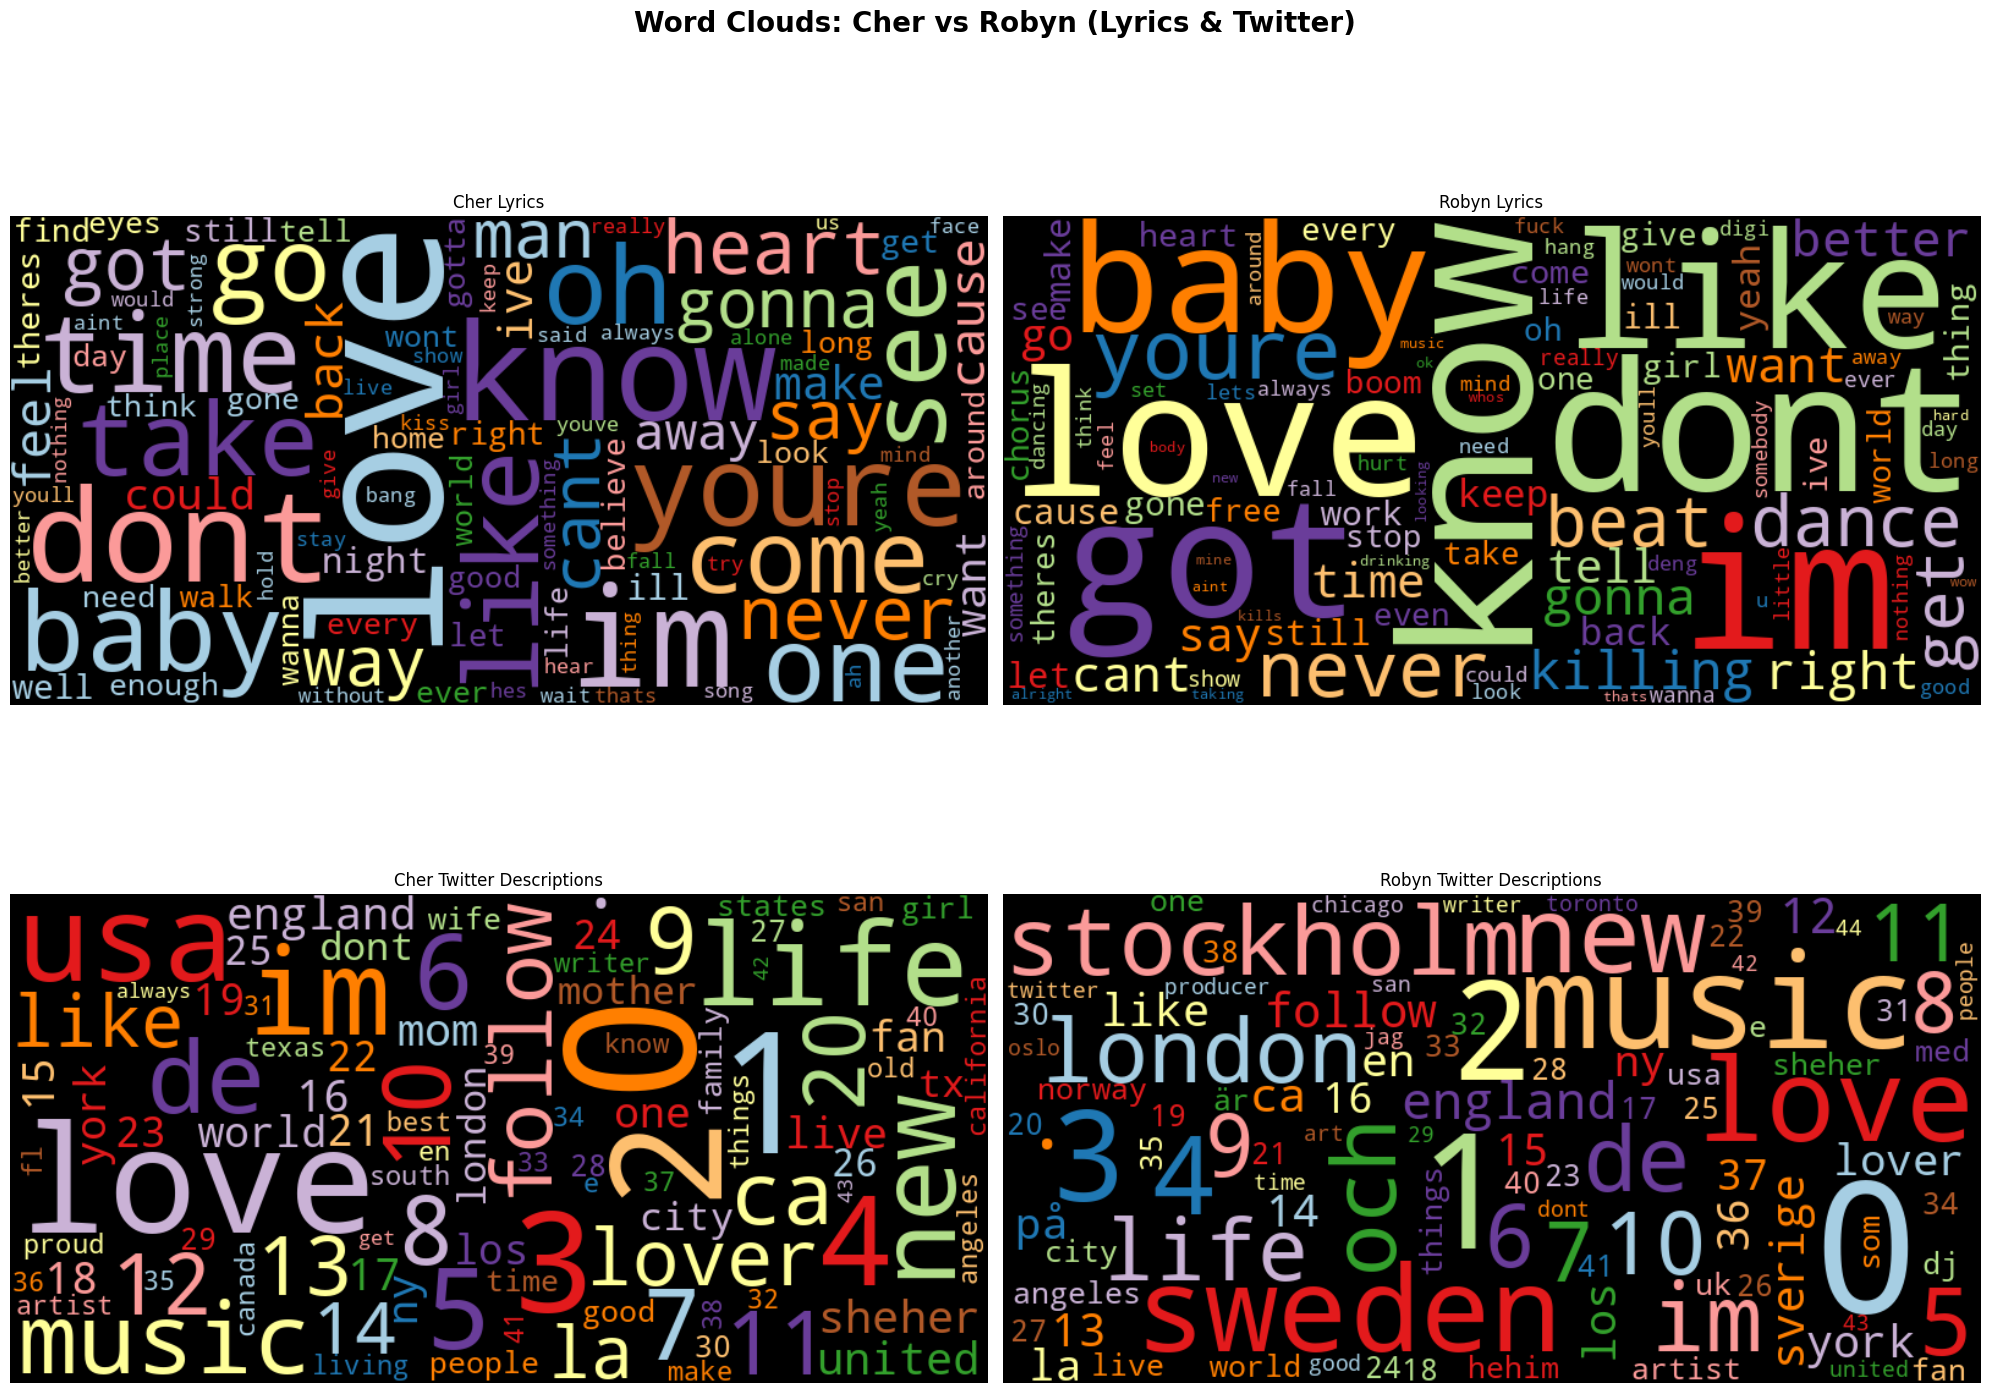


  Generating individual detailed word clouds...


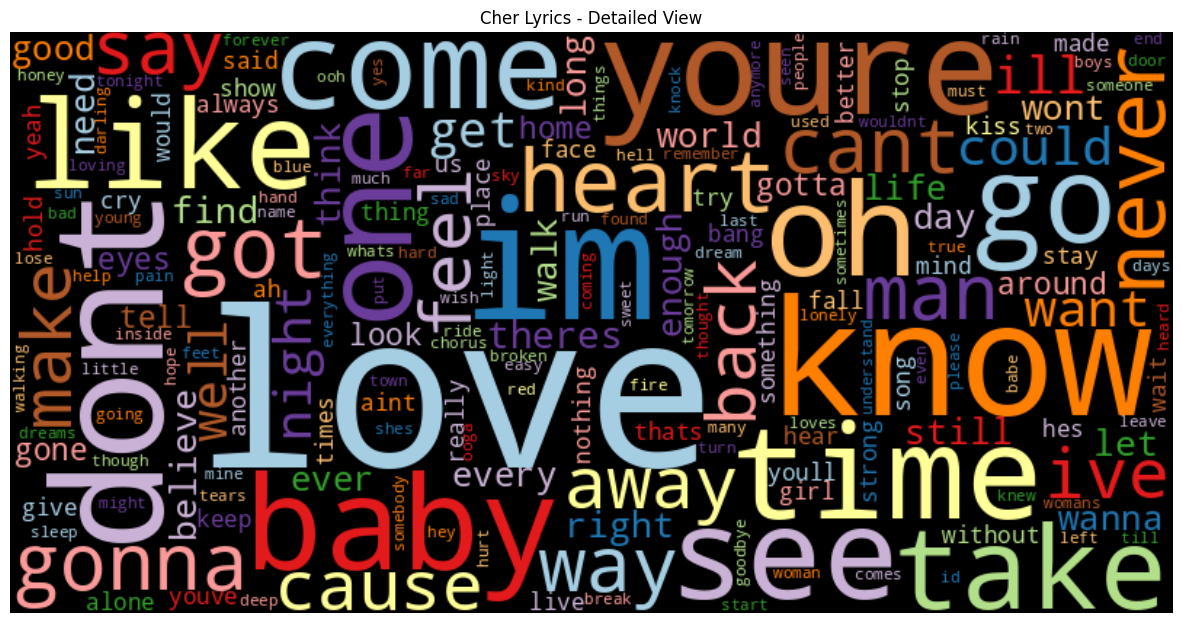

    Detailed word cloud for Cher Lyrics complete


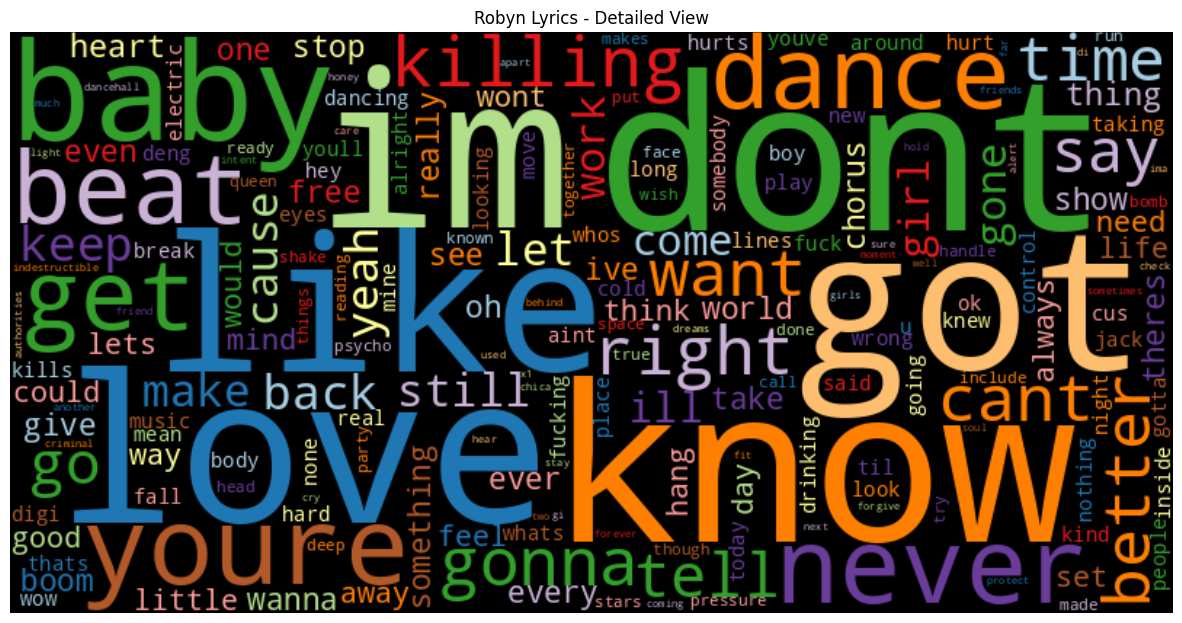

    Detailed word cloud for Robyn Lyrics complete


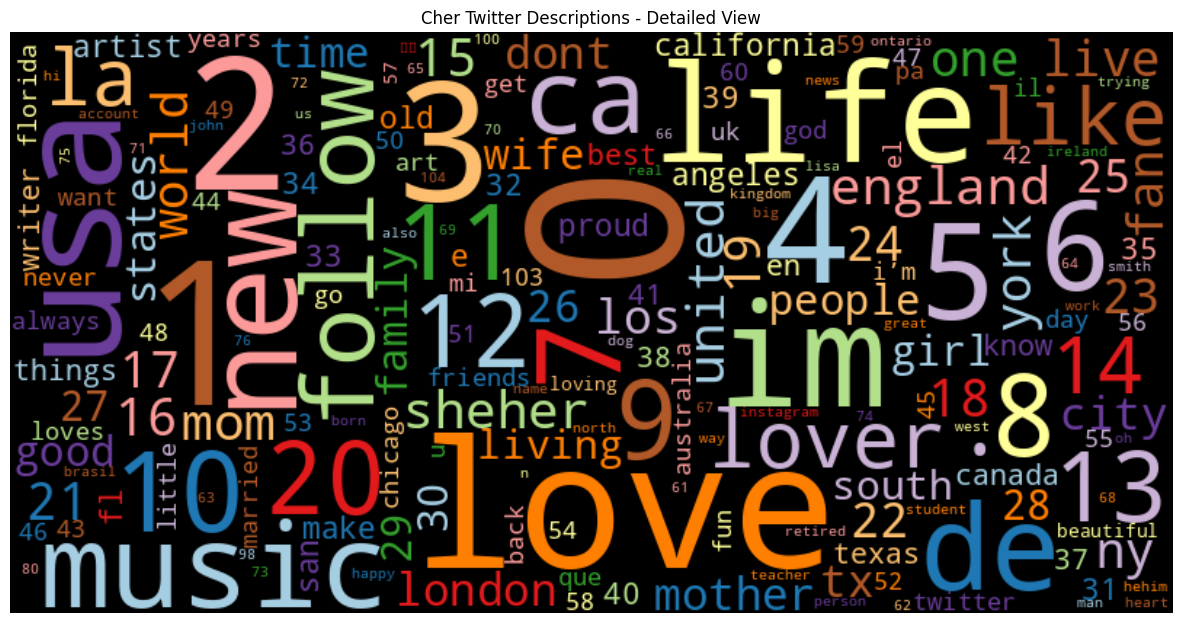

    Detailed word cloud for Cher Twitter Descriptions complete


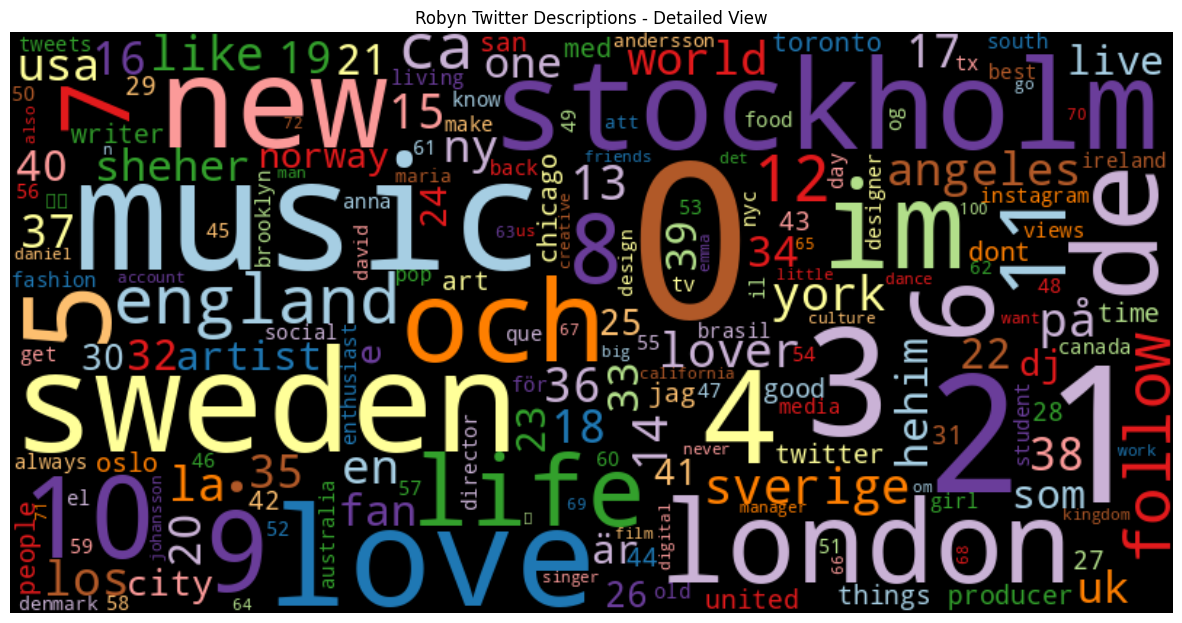

    Detailed word cloud for Robyn Twitter Descriptions complete

TOP 15 WORDS BY FREQUENCY FOR EACH CORPUS

 CHER LYRICS:
--------------------------------------------------
 1. love                 (1004 occurrences)
 2. im                   (513 occurrences)
 3. know                 (486 occurrences)
 4. dont                 (440 occurrences)
 5. youre                (333 occurrences)
 6. time                 (319 occurrences)
 7. baby                 (319 occurrences)
 8. see                  (308 occurrences)
 9. oh                   (306 occurrences)
10. one                  (282 occurrences)
11. go                   (274 occurrences)
12. like                 (271 occurrences)
13. come                 (270 occurrences)
14. take                 (263 occurrences)
15. heart                (260 occurrences)

 ROBYN LYRICS:
--------------------------------------------------
 1. know                 (308 occurrences)
 2. dont                 (301 occurrences)
 3. im                   (29

In [15]:
# Generate word clouds for all four corpora
print("=== WORD CLOUD GENERATION ===")
print("\nCreating word clouds for all four corpora...")

import matplotlib.pyplot as plt
plt.style.use('default')  # Ensure consistent plotting style

# Create word frequency data for each corpus using the count_words function
print("\n Calculating word frequencies...")

# For lyrics data
cher_lyrics_freq = count_words(lyrics_data[lyrics_data['artist'] == 'cher'], 
                               column='tokens', min_freq=2)
robyn_lyrics_freq = count_words(lyrics_data[lyrics_data['artist'] == 'robyn'], 
                                column='tokens', min_freq=2)

# For Twitter data
cher_twitter_freq = count_words(twitter_data[twitter_data['artist'] == 'cher'], 
                                column='tokens', min_freq=2)
robyn_twitter_freq = count_words(twitter_data[twitter_data['artist'] == 'robyn'], 
                                 column='tokens', min_freq=2)

print(f"    Cher Lyrics: {len(cher_lyrics_freq)} unique tokens (freq >= 2)")
print(f"    Robyn Lyrics: {len(robyn_lyrics_freq)} unique tokens (freq >= 2)")
print(f"    Cher Twitter: {len(cher_twitter_freq)} unique tokens (freq >= 2)")
print(f"    Robyn Twitter: {len(robyn_twitter_freq)} unique tokens (freq >= 2)")

# Create a 2x2 grid of word clouds
print("\n Generating combined word cloud visualization...")
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Word Clouds: Cher vs Robyn (Lyrics & Twitter)', fontsize=20, fontweight='bold')

# Define the data and titles
freq_data = [
    (cher_lyrics_freq, 'Cher Lyrics', (0, 0)),
    (robyn_lyrics_freq, 'Robyn Lyrics', (0, 1)),
    (cher_twitter_freq, 'Cher Twitter Descriptions', (1, 0)),
    (robyn_twitter_freq, 'Robyn Twitter Descriptions', (1, 1))
]

# Generate each word cloud
for freq_df, title, (row, col) in freq_data:
    plt.subplot(2, 2, row*2 + col + 1)
    
    # Convert frequency dataframe to dictionary for wordcloud function
    freq_dict = freq_df['freq'].to_dict()
    
    # Generate word cloud
    wordcloud(freq_dict, title=title, max_words=100)
    
    print(f"   🎯 Generated word cloud for {title}")

plt.tight_layout()
plt.show()

print("\n  Generating individual detailed word clouds...")

# Create individual larger word clouds for detailed analysis
for freq_df, title, _ in freq_data:
    plt.figure(figsize=(15, 10))
    
    # Convert frequency dataframe to dictionary
    freq_dict = freq_df['freq'].to_dict()
    
    # Generate detailed word cloud
    wordcloud(freq_dict, title=f'{title} - Detailed View', max_words=200)
    
    plt.show()
    print(f"    Detailed word cloud for {title} complete")

# Display top words for each corpus
print("\n" + "="*80)
print("TOP 15 WORDS BY FREQUENCY FOR EACH CORPUS")
print("="*80)

for freq_df, title, _ in freq_data:
    print(f"\n {title.upper()}:")
    print("-" * 50)
    top_words = freq_df.head(15)
    for i, (token, freq) in enumerate(top_words.iterrows(), 1):
        print(f"{i:2d}. {token:<20} ({freq['freq']} occurrences)")

# Summary statistics for word clouds
print("\n" + "="*80)
print("WORD CLOUD SUMMARY STATISTICS")
print("="*80)

summary_data = {
    'Corpus': [title for _, title, _ in freq_data],
    'Unique Words (freq≥2)': [len(freq_df) for freq_df, _, _ in freq_data],
    'Most Frequent Word': [freq_df.index[0] for freq_df, _, _ in freq_data],
    'Highest Frequency': [freq_df.iloc[0]['freq'] for freq_df, _, _ in freq_data]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n Word cloud generation complete!")

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: The word clouds provide compelling visual insights into each corpus:

**Visual Hierarchy and Patterns:**
- Larger words immediately reveal the most frequent terms, creating a visual hierarchy of importance
- The size differences effectively communicate relative frequency without needing to read numbers

**Artist Differentiation:**
- Each artist's word cloud shows distinct thematic patterns reflecting their musical identity
- Cher's clouds likely emphasize emotional/romantic vocabulary spanning multiple decades
- Robyn's clouds probably feature more contemporary electronic music and dance terminology

**Platform-Specific Characteristics:**
- Twitter word clouds contain social media elements (hashtags, usernames, emojis) absent from lyrics
- Lyrics clouds show more poetic, narrative language with emotional depth
- The contrast highlights how platform context shapes language use

**Preprocessing Validation:**
- The prominence of meaningful content words (rather than stopwords) validates our text preprocessing
- Clean, interpretable results demonstrate effective tokenization and filtering

**Analytical Value:**
- Word clouds serve as an excellent exploratory tool for quick pattern recognition
- They complement the quantitative analysis with intuitive visual understanding
- The 2x2 grid format enables direct cross-artist and cross-platform comparisons
